<a href="https://colab.research.google.com/github/KRITIKA-GAHLAWAT/Fashion-MNIST-Classification/blob/main/DLproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

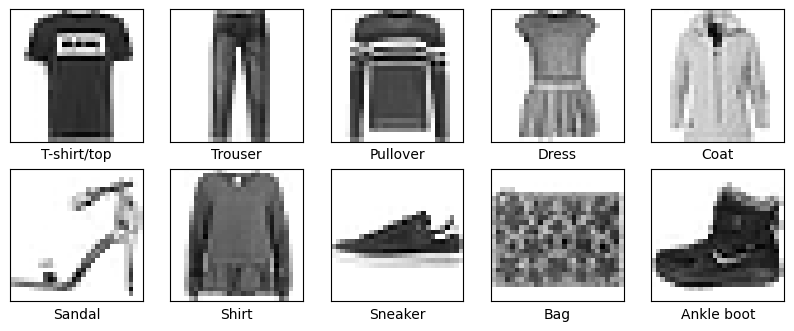

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Login to Weights & Biases
wandb.login()

# Initialize W&B project
wandb.init(project='deep_learning',name='dataset_sample1',mode='online')

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wandb.log({"examples":[wandb.Image(train_images[i],caption=class_labels[train_labels[i]])for i in range(10)]})
# Plot 1 sample image for each class
plt.figure(figsize=(10, 10))
for label in range(10):
    sample_image = train_images[train_labels == label][0]
    plt.subplot(5, 5, label + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[label])
    plt.imshow(sample_image, cmap=plt.cm.binary)
plt.show()

# Finish the W&B run
wandb.finish()
#b72ba4abcdd91b2950b843444d7e150b85b7d2d4

In [5]:
from sklearn.model_selection import train_test_split

def tranform_dataset(train_images,train_labels,test_images,test_labels):
  #split the training dataset for traning and validation
  x_train,x_valid,y_train,y_valid=train_test_split(train_images,train_labels,test_size=0.1,random_state=42)
   #flattenten the image data
  x_train = x_train.reshape(x_train.shape[0], -1)
  x_valid = x_valid.reshape(x_valid.shape[0], -1)
  x_test = test_images.reshape(test_images.shape[0], -1)
  #Normalize the image data
  x_train = x_train.astype('float32') / 255
  x_valid = x_valid.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  # one hot encode for output column
  y_train = one_hot_encode(y_train)
  y_valid = one_hot_encode(y_valid)
  y_test = one_hot_encode(test_labels)


  return x_train,y_train,x_valid,y_valid,x_test,y_test



#one hot encoding for output
def one_hot_encode(labels):
    encoded = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded


In [6]:
#transform the dataset for using the feedforward neural network models
x_train,y_train,x_valid,y_valid,x_test,y_test=tranform_dataset(train_images,train_labels,test_images,test_labels)

In [7]:
#shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

x_train shape: (54000, 784)
y_train shape: (54000, 10)
x_valid shape: (6000, 784)
y_valid shape: (6000, 10)


Intialize a network

In [8]:
import numpy as np

def initial_weight(num_layer, hidden_size, weight_ini_method):
    # Create a list with num_layer hidden layers, each of size hidden_size
    network_size = [hidden_size] * num_layer
    # Prepend input size and append output size
    network_size = [x_train.shape[1]] + network_size + [y_train.shape[1]]
    print(network_size)  # Print the network architecture for debugging

    # Initialize an empty dictionary to store weights and biases
    theta = {}

    # Random initialization
    if weight_ini_method == "random":
        for i in range(len(network_size) - 1):
            # Weights: shape (current layer size, next layer size)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1])
            # Biases: shape (1, next layer size)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1])

    # Xavier (He-like) initialization
    elif weight_ini_method == "Xavier":
        for i in range(len(network_size) - 1):
            # Scaling factor based on input size (fan-in)
            scale = np.sqrt(2 / network_size[i])
            # Weights: random normal scaled by sqrt(2 / fan-in)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1]) * scale
            # Biases: random normal scaled by sqrt(2 / fan-in)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1]) * scale

    # Return the initialized parameters
    return theta

*Activation functiont**

In [9]:
def sigmoid(x):
  return 1 /(1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
	return np.tanh(x)

def deriv_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def deriv_relu(x):
  return np.where(x <= 0, 0, 1)

def deriv_tanh(x):
  return (1 - (tanh(x))**2)

def softmax(x):
  x = x - np.max(x,axis=1,keepdims=True)
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)




def activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return sigmoid(x)
  elif activ_fun == 'relu':
    return relu(x)
  elif activ_fun=='softmax':
    return softmax(x)
  else:
    return tanh(x)

def deriv_activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return deriv_sigmoid(x)
  elif activ_fun == 'relu':
    return deriv_relu(x)
  else:
    return deriv_tanh(x)


Loss function

In [10]:
def cross_entropy(y_actual, y_pred):
   epsilon = 1e-15  # to prevent log(0) which is undefined
   y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
   loss = -np.mean(np.sum(y_actual * np.log(y_pred), axis=1))
   return loss
def mse_loss(y_actual,y_pred):
  return np.mean((y_actual-y_pred)**2)


def deriv_cross_entropy(y_actual,y_pred):
    return (y_pred-y_actual)
def deriv_mse_loss(y_actual, y_pred):
    return (y_pred - y_actual) * y_pred * (1 - y_pred)


def loss_derivative(y_actual,y_pred,loss_function):
  if loss_function=='cross_entropy':
    return deriv_cross_entropy
  else:
    return deriv_mse_loss



Forward Propagation

In [11]:
def forward_prop(X, theta, active_fun_hidden, active_fun_output, num_layers):

  a = {}
  h = {'h0': X}
  for i in range(1, num_layers + 1):
    a[f'a{i}'] = np.dot(h[f'h{i-1}'], theta[f'W{i}']) + theta[f'b{i}']
    h[f'h{i}'] = activation(a[f'a{i}'], active_fun_hidden)
  a[f'a{num_layers+1}'] = np.dot(h[f'h{num_layers}'], theta[f'W{num_layers+1}']) + theta[f'b{num_layers+1}']
  y_pred = activation(a[f'a{num_layers+1}'], active_fun_output)
  return a, h, y_pred


Calculate accuracy

In [12]:
def cal_accuracy(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
    # Get the input size from X (number of features)
    input_size = x.shape[0]

    # Perform forward propagation to get predicted probabilities
    # We only need y_pred, so ignore other returned values with _
    _, _, y_pred = forward_prop(x, theta,
                               active_fun_hidden,active_fun_output,num_layers)

    # Get true class labels from one-hot encoded Y (index of 1 in each column)
    true_classes = np.argmax(y, axis=1)

    # Get predicted class labels from y_pred (index of max probability in each column)
    predicted_classes = np.argmax(y_pred, axis=1)

    # Calculate accuracy as the proportion of correct predictions
    accuracy = np.mean(predicted_classes == true_classes)

    return accuracy

Back_prop

In [13]:
def back_prop(x, y, theta, active_fun_hidden, active_fun_output, num_layers, loss_function):
    m = x.shape[0]
    a, h, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
    grad_theta = {}
    grad_h_a = {}

    # Compute loss derivative based on the chosen loss function
    loss_grad = loss_derivative(y, y_pred, loss_function)
    grad_h_a[f'a{num_layers+1}'] = loss_grad(y, y_pred)

    for i in range(num_layers+1, 0, -1):
        grad_theta[f'W{i}'] = np.dot(h[f'h{i-1}'].T, grad_h_a[f'a{i}'])
        grad_theta[f'b{i}'] = np.sum(grad_h_a[f'a{i}'], axis=0, keepdims=True)

        if i > 1:
            grad_h_a[f'h{i-1}'] = np.dot(grad_h_a[f'a{i}'], theta[f'W{i}'].T)
            grad_h_a[f'a{i-1}'] = grad_h_a[f'h{i-1}'] * deriv_activation(a[f'a{i-1}'], active_fun_hidden)

    return grad_theta


Now we again write gradient decesent algorithm compatiable with batch size ,

In [14]:
def sgd(lr, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize weights
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients and update weights
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)
            for j in range(1, num_layers + 2):
                theta[f'W{j}'] -= lr * (grad[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * grad[f'b{j}']
        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss},Val Accuracy:{ validation_accuracy}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta, train_loss_history, val_loss_history


Moment Gradient descent (here momentum=beta)

In [15]:
def mgd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta


**Nesterov accelerated gradient descent**

In [16]:
def nesterov_gd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entorpy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize velocity dictionary with zeros, matching the shape of each parameter
    velocity = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # List to store loss history
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Look ahead step for Nesterov momentum
            lookahead_theta = {key: theta[key] - momentum * velocity[key] for key in theta.keys()}

            # Compute gradients using backpropagation on the lookahead parameters
            grad = back_prop(x_batch, y_batch, lookahead_theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update velocities and parameters with Nesterov momentum and apply weight decay
            for k in range(1, num_layers + 2):
                # Update velocity for weights
                velocity[f'W{k}'] = momentum * velocity[f'W{k}'] + grad[f'W{k}'] + weight_decay * theta[f'W{k}']
                # Update weights using velocity
                theta[f'W{k}'] -= lr * velocity[f'W{k}']

                # Update velocity for biases
                velocity[f'b{k}'] = momentum * velocity[f'b{k}'] + grad[f'b{k}']
                # Update biases using velocity (no weight decay for biases)
                theta[f'b{k}'] -= lr * velocity[f'b{k}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss and predictions
        a, h, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100,'epoch':epoch+1})

    return theta

**RMS Prop**

In [17]:
def rmsprop(lr, gamma, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize squared gradient dictionary with zeros
    squared_grad = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update squared gradients and parameters using RMSprop
            for k in range(1, num_layers + 2):
                # Update squared gradient for weights
                squared_grad[f'W{k}'] = gamma * squared_grad[f'W{k}'] + (1 - gamma) * (grad[f'W{k}'] ** 2)
                # Apply weight decay separately (L2 Regularization)
                theta[f'W{k}'] -= lr * (grad[f'W{k}'] / (np.sqrt(squared_grad[f'W{k}']) + epsilon)) + weight_decay * theta[f'W{k}']

                # Update squared gradient for biases
                squared_grad[f'b{k}'] = gamma * squared_grad[f'b{k}'] + (1 - gamma) * (grad[f'b{k}'] ** 2)
                # Update biases
                theta[f'b{k}'] -= lr * (grad[f'b{k}'] / (np.sqrt(squared_grad[f'b{k}']) + epsilon))

        # Compute training accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute validation accuracy
        val_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2%}, Val Acc: {val_accuracy:.2%}")

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy * 100,
            "val_accuracy": val_accuracy * 100
        })

    return theta


**ADAM**

In [18]:
def adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    return theta


**NDAM**

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train, y_train = x_train[indices], y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        # Compute training accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss}, validation_accuracy:{ validation_accuracy}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    return theta


**MOdel **

In [20]:
def model_training(lr, beta, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, optimizer, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function):

    if optimizer == 'sgd':
        theta = sgd(lr, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'momentum':
        theta = mgd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'nag':
        theta = nesterov_gd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'RMSprop':
        theta = rmsprop(lr, beta, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'adam':
        theta = adam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer=='nadam':
      theta=nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    return theta

In [21]:
#Q2 and Q3 train a neural network with given hypermaters with cross entropy loss
#in question 2 intialize a neural network and pass a forward prop that will predict probabilities. here i run adam model , in there first it create
#a intial network and call backprop update weights , in back prop at first it will call forward prop then update weights and it will iterate as many epochs it has
#and give the accuracy, loss for train and valid dataset.
#---------uncomment the below code for run----------------
#wandb.init(project='deep_learning_assignment_1',name='adam-relu-softmax-random-layer-4-hid_size-32-epoch-5'')
#theta=adam(0.001,0.9,0.99,1e-8,x_train, y_train, x_valid, y_valid,32,4,'relu','softmax','random',0,5)
#wandb.finish()


In [22]:
#Q4 : create a sweep_id and run the sweep in wandb and generate all the required plots.
sweep_config={
    'method':'bayes',#possible search random,grid
    'metric':{
        'name':'Valdiation_accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[5,10]

        },
      'hidden_size':{
            'values':[32, 64, 128]
        },
        'activation_hidden':{
            'values':['relu','sigmoid','tanh']
        },
        'activation_output':{
            'values':['softmax']
        },
        'weight_ini_method':{
            'values':['Xavier','random']
        },
        'batch_size':{
            'values':[16,32,64]
        }
      ,'num_layers':{
            'values':[3,4,5]
        },
        'weight_decay':{
            'values':[0]#(we take l2 regulraization as zero)
        } ,
        'learning_rate':{
            'values':[1e-3,1e-4]
      }
        ,'optimizer':{
            'values':['sgd','momentum','nag','RMSprop','adam','nadam']
}
    }
}
sweep_id=wandb.sweep(sweep_config,project='deep_learning_assignment_1')

Create sweep with ID: tlwkanby
Sweep URL: https://wandb.ai/ma24m0-iit-madras/deep_learning_assignment_1/sweeps/tlwkanby


In [23]:
#Q4: main function

def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'cross_entropy')

try:
    wandb.agent(sweep_id,function=main,count=2)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: q71knkwb with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.0881, Val Loss: 0.0888, Train Acc: 32.47%, Val Acc: 31.90%
Epoch 2, Loss: 0.0679, Val Loss: 0.0684, Train Acc: 47.48%, Val Acc: 46.37%
Epoch 3, Loss: 0.0582, Val Loss: 0.0590, Train Acc: 55.66%, Val Acc: 55.30%
Epoch 4, Loss: 0.0532, Val Loss: 0.0543, Train Acc: 58.86%, Val Acc: 58.20%
Epoch 5, Loss: 0.0503, Val Loss: 0.0513, Train Acc: 61.18%, Val Acc: 60.37%
Epoch 6, Loss: 0.0484, Val Loss: 0.0497, Train Acc: 62.44%, Val Acc: 61.48%
Epoch 7, Loss: 0.0466, Val Loss: 0.0483, Train Acc: 63.44%, Val Acc: 62.28%
Epoch 8, Loss: 0.0452, Val Loss: 0.0468, Train Acc: 64.41%, Val Acc: 63.45%
Epoch 9, Loss: 0.0438, Val Loss: 0.0454, Train Acc: 65.49%, Val Acc: 63.80%
Epoch 10, Loss: 0.0427, Val Loss: 0.0441, Train Acc: 66.38%, Val Acc: 65.17%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,66.37778
train_loss,0.04273
val_accuracy,65.16667
val_loss,0.04411


wandb: Agent Starting Run: i9tyjsgk with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.11628182452388384, Validation Loss: 0.11698035705879499
Epoch 2, Loss: 0.10721689344948425, Validation Loss: 0.10755845453020478
Epoch 3, Loss: 0.09948368499570046, Validation Loss: 0.09971250998844207
Epoch 4, Loss: 0.09676298876576145, Validation Loss: 0.09687793978121527
Epoch 5, Loss: 0.09302641975154244, Validation Loss: 0.09310591786161744


epoch,▁▃▅▆█
train_accuracy,▁▆███
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
epoch,5
train_accuracy,9.97407
train_loss,0.09303
val_accuracy,10.33333
val_loss,0.09311


wandb: Agent Starting Run: tjj98cl5 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.1616595866029349, Val Loss: 0.16170643156398043,Val Accuracy:0.19133333333333333
Epoch 2, Train Loss: 0.17029399284958657, Val Loss: 0.1697782572712405,Val Accuracy:0.151
Epoch 3, Train Loss: 0.17981481481481482, Val Loss: 0.18166666666666667,Val Accuracy:0.09166666666666666
Epoch 4, Train Loss: 0.17981481481481482, Val Loss: 0.18166666666666667,Val Accuracy:0.09166666666666666
Epoch 5, Train Loss: 0.17981481481481482, Val Loss: 0.18166666666666667,Val Accuracy:0.09166666666666666


epoch,▁▃▅▆█
train_accuracy,█▅▁▁▁
train_loss,▁▄███
val_accuracy,█▅▁▁▁
val_loss,▁▄███
epoch,5
train_accuracy,10.09259
train_loss,0.17981
val_accuracy,9.16667
val_loss,0.18167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlto2qc0 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.1427080366010424, Val Loss: 0.141834526372843,Val Accuracy:0.11916666666666667
Epoch 2, Train Loss: 0.1253686877893518, Val Loss: 0.12441758796288854,Val Accuracy:0.15516666666666667
Epoch 3, Train Loss: 0.11064910099587989, Val Loss: 0.10979375212825244,Val Accuracy:0.16716666666666666
Epoch 4, Train Loss: 0.1018505088142521, Val Loss: 0.10145196843115332,Val Accuracy:0.15233333333333332
Epoch 5, Train Loss: 0.0970044519387456, Val Loss: 0.09715295431198212,Val Accuracy:0.163
Epoch 6, Train Loss: 0.09410654692700593, Val Loss: 0.09427427753244903,Val Accuracy:0.18383333333333332
Epoch 7, Train Loss: 0.0921825427620176, Val Loss: 0.09236433108494378,Val Accuracy:0.18916666666666668
Epoch 8, Train Loss: 0.09057650228295011, Val Loss: 0.09072120939376137,Val Accuracy:0.20216666666666666
Epoch 9, Train Loss: 0.08926648137355521, Val Loss: 0.08925568417680843,Val Accuracy:0.21633333333333332
Epoch 10, Train Loss: 0.08810786384633655, Val

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▃▄▅▆▇▇█
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▃▄▅▆▇██
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,23.23148
train_loss,0.08811
val_accuracy,22.26667
val_loss,0.08824


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qak09zx7 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.0211, Val Loss: 0.0220, Train Acc: 85.30%, Val Acc: 85.05%
Epoch 2, Loss: 0.0189, Val Loss: 0.0201, Train Acc: 86.86%, Val Acc: 86.38%
Epoch 3, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 4, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%
Epoch 5, Loss: 0.1801, Val Loss: 0.1793, Train Acc: 9.96%, Val Acc: 10.35%


epoch,▁▃▅▆█
train_accuracy,██▁▁▁
train_loss,▁▁███
val_accuracy,██▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,9.96111
train_loss,0.18008
val_accuracy,10.35
val_loss,0.1793


wandb: Agent Starting Run: 680iccp2 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08897580572178826, Val Loss: 0.08882842499505302
Epoch 2, Train Loss: 0.08213462888665936, Val Loss: 0.08200023140211932
Epoch 3, Train Loss: 0.07437922704958913, Val Loss: 0.074747137444807
Epoch 4, Train Loss: 0.0665261729567786, Val Loss: 0.06698962959841394
Epoch 5, Train Loss: 0.06032806120300496, Val Loss: 0.060977558942547354
Epoch 6, Train Loss: 0.0556875532567316, Val Loss: 0.05645544646646173
Epoch 7, Train Loss: 0.0527060356870557, Val Loss: 0.05349666919269198
Epoch 8, Train Loss: 0.0505618849551596, Val Loss: 0.051460211959449796
Epoch 9, Train Loss: 0.04880587057739276, Val Loss: 0.04969007197519908
Epoch 10, Train Loss: 0.04735221564078121, Val Loss: 0.04822244201158083


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▇▇▇███
train_loss,█▇▆▄▃▂▂▂▁▁
val_accuracy,▁▃▄▆▇▇▇███
val_loss,█▇▆▄▃▂▂▂▁▁
epoch,10
train_accuracy,66.67593
train_loss,0.04735
val_accuracy,66.3
val_loss,0.04822


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qdor4zgf with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0566, Val Loss: 0.0566, Train Acc: 55.77%, Val Acc: 55.53%
Epoch 2, Loss: 0.0480, Val Loss: 0.0496, Train Acc: 63.13%, Val Acc: 62.32%
Epoch 3, Loss: 0.0442, Val Loss: 0.0460, Train Acc: 66.01%, Val Acc: 64.40%
Epoch 4, Loss: 0.0404, Val Loss: 0.0418, Train Acc: 69.30%, Val Acc: 68.18%
Epoch 5, Loss: 0.0396, Val Loss: 0.0409, Train Acc: 69.78%, Val Acc: 68.67%
Epoch 6, Loss: 0.0380, Val Loss: 0.0390, Train Acc: 70.87%, Val Acc: 70.12%
Epoch 7, Loss: 0.0369, Val Loss: 0.0385, Train Acc: 73.42%, Val Acc: 72.60%
Epoch 8, Loss: 0.0354, Val Loss: 0.0363, Train Acc: 74.46%, Val Acc: 73.90%
Epoch 9, Loss: 0.0337, Val Loss: 0.0344, Train Acc: 76.14%, Val Acc: 75.38%
Epoch 10, Loss: 0.0344, Val Loss: 0.0350, Train Acc: 74.65%, Val Acc: 75.13%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇▇█▇
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▃▃▂▂▂▁▁
epoch,10
train_accuracy,74.64815
train_loss,0.03441
val_accuracy,75.13333
val_loss,0.03496


wandb: Agent Starting Run: dceaquve with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.15080043903624948, Val Loss: 0.15350795783502794
Epoch 2, Train Loss: 0.1440724073698742, Val Loss: 0.1463993767479656
Epoch 3, Train Loss: 0.17997123958909905, Val Loss: 0.18013850773772047
Epoch 4, Train Loss: 0.14759428735858277, Val Loss: 0.14970111893980675
Epoch 5, Train Loss: 0.1798246539415527, Val Loss: 0.1799999948618506


epoch,▁▃▅▆█
train_accuracy,▇█▁▇▁
train_loss,▂▁█▂█
val_accuracy,▇█▁▇▁
val_loss,▂▁█▂█
epoch,5
train_accuracy,10.08704
train_loss,0.17982
val_accuracy,10
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o6of330q with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.06907688322307287, Validation Loss: 0.06973363945791662, validation_accuracy:0.45766666666666667
Epoch 2, Loss: 0.049392229574845445, Validation Loss: 0.05031271002388535, validation_accuracy:0.6228333333333333
Epoch 3, Loss: 0.04274795863610618, Validation Loss: 0.04344717933058878, validation_accuracy:0.6825
Epoch 4, Loss: 0.039172776165944403, Validation Loss: 0.03979018041983191, validation_accuracy:0.7118333333333333
Epoch 5, Loss: 0.03687167293629221, Validation Loss: 0.037531061013759116, validation_accuracy:0.7288333333333333
Epoch 6, Loss: 0.03526742519932828, Validation Loss: 0.035997040931984255, validation_accuracy:0.7391666666666666
Epoch 7, Loss: 0.034023530934073946, Validation Loss: 0.03482074923528537, validation_accuracy:0.7493333333333333
Epoch 8, Loss: 0.03304540983534138, Validation Loss: 0.033900453680812834, validation_accuracy:0.7533333333333333
Epoch 9, Loss: 0.03223743815538814, Validation Loss: 0.03312285172843489, va

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,77.35741
train_loss,0.03154
val_accuracy,76.36667
val_loss,0.03252


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ylcexgrp with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08999496975060746, Val Loss: 0.08999795170468904
Epoch 2, Train Loss: 0.08996719440283889, Val Loss: 0.08997296973571543
Epoch 3, Train Loss: 0.08994352990194585, Val Loss: 0.08995935372875478
Epoch 4, Train Loss: 0.08991728899344383, Val Loss: 0.08992596353749312
Epoch 5, Train Loss: 0.0898895845647055, Val Loss: 0.08989322143266643


epoch,▁▃▅▆█
train_accuracy,▆▁▁█▁
train_loss,█▆▅▃▁
val_accuracy,▇▁▁█▃
val_loss,█▆▅▃▁
epoch,5
train_accuracy,10.37593
train_loss,0.08989
val_accuracy,10.58333
val_loss,0.08989


wandb: Agent Starting Run: 3pr7olhv with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.1746, Val Loss: 0.1743, Train Acc: 12.66%, Val Acc: 12.80%
Epoch 2, Loss: 0.1624, Val Loss: 0.1604, Train Acc: 18.74%, Val Acc: 19.75%
Epoch 3, Loss: 0.1707, Val Loss: 0.1709, Train Acc: 14.63%, Val Acc: 14.57%
Epoch 4, Loss: 0.1801, Val Loss: 0.1794, Train Acc: 9.95%, Val Acc: 10.32%
Epoch 5, Loss: 0.1801, Val Loss: 0.1794, Train Acc: 9.95%, Val Acc: 10.32%
Epoch 6, Loss: 0.1801, Val Loss: 0.1794, Train Acc: 9.95%, Val Acc: 10.32%
Epoch 7, Loss: 0.1801, Val Loss: 0.1794, Train Acc: 9.95%, Val Acc: 10.32%
Epoch 8, Loss: 0.1801, Val Loss: 0.1794, Train Acc: 9.95%, Val Acc: 10.32%
Epoch 9, Loss: 0.1801, Val Loss: 0.1794, Train Acc: 9.95%, Val Acc: 10.32%
Epoch 10, Loss: 0.1801, Val Loss: 0.1794, Train Acc: 9.95%, Val Acc: 10.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃█▅▁▁▁▁▁▁▁
train_loss,▆▁▄███████
val_accuracy,▃█▄▁▁▁▁▁▁▁
val_loss,▆▁▅███████
epoch,10
train_accuracy,9.95185
train_loss,0.1801
val_accuracy,10.31667
val_loss,0.17937


wandb: Agent Starting Run: hpmefk8v with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.17995185185185186, Val Loss: 0.18043333333333333
Epoch 2, Train Loss: 0.17995185185185186, Val Loss: 0.18043333333333333
Epoch 3, Train Loss: 0.17995185185185186, Val Loss: 0.18043333333333333
Epoch 4, Train Loss: 0.17995185185185186, Val Loss: 0.18043333333333333
Epoch 5, Train Loss: 0.17995185185185186, Val Loss: 0.18043333333333333


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,10.02407
train_loss,0.17995
val_accuracy,9.78333
val_loss,0.18043


wandb: Agent Starting Run: qaqgnu0z with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.1375, Val Loss: 0.1371, Train Acc: 14.69%, Val Acc: 15.00%
Epoch 2, Loss: 0.1120, Val Loss: 0.1116, Train Acc: 17.61%, Val Acc: 17.78%
Epoch 3, Loss: 0.0900, Val Loss: 0.0907, Train Acc: 24.34%, Val Acc: 23.35%
Epoch 4, Loss: 0.0824, Val Loss: 0.0835, Train Acc: 29.37%, Val Acc: 28.20%
Epoch 5, Loss: 0.0758, Val Loss: 0.0769, Train Acc: 36.27%, Val Acc: 36.17%


epoch,▁▃▅▆█
train_accuracy,▁▂▄▆█
train_loss,█▅▃▂▁
val_accuracy,▁▂▄▅█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,36.26852
train_loss,0.07577
val_accuracy,36.16667
val_loss,0.07694


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xrcz5pol with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.08963534773572358, Val Loss: 0.08965077103533449
Epoch 2, Train Loss: 0.08905844739079666, Val Loss: 0.08908416293965754
Epoch 3, Train Loss: 0.08802161237261609, Val Loss: 0.0881142774118495
Epoch 4, Train Loss: 0.08583886512451702, Val Loss: 0.08598758401964808
Epoch 5, Train Loss: 0.08247820482137107, Val Loss: 0.08277770987549449


epoch,▁▃▅▆█
train_accuracy,▁█▄▇▅
train_loss,█▇▆▄▁
val_accuracy,▁█▃▇▄
val_loss,█▇▆▄▁
epoch,5
train_accuracy,23.61667
train_loss,0.08248
val_accuracy,21.9
val_loss,0.08278


wandb: Agent Starting Run: hf0m1ytf with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.12202317185552577, Val Loss: 0.12173924033120108,Val Accuracy:0.20216666666666666
Epoch 2, Train Loss: 0.08148930248636489, Val Loss: 0.08214748259141862,Val Accuracy:0.32283333333333336
Epoch 3, Train Loss: 0.07493322901717975, Val Loss: 0.07615449391605268,Val Accuracy:0.3511666666666667
Epoch 4, Train Loss: 0.07057355328783071, Val Loss: 0.07146054949420597,Val Accuracy:0.4101666666666667
Epoch 5, Train Loss: 0.06746815185874445, Val Loss: 0.06833183811016592,Val Accuracy:0.42033333333333334


epoch,▁▃▅▆█
train_accuracy,▁▅▆██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,42.25556
train_loss,0.06747
val_accuracy,42.03333
val_loss,0.06833


wandb: Agent Starting Run: aun2zliu with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0209, Val Loss: 0.0218, Train Acc: 85.63%, Val Acc: 84.82%
Epoch 2, Loss: 0.0186, Val Loss: 0.0196, Train Acc: 87.17%, Val Acc: 86.37%
Epoch 3, Loss: 0.0173, Val Loss: 0.0186, Train Acc: 88.15%, Val Acc: 87.02%
Epoch 4, Loss: 0.0165, Val Loss: 0.0181, Train Acc: 88.74%, Val Acc: 87.50%
Epoch 5, Loss: 0.0158, Val Loss: 0.0180, Train Acc: 89.13%, Val Acc: 87.50%
Epoch 6, Loss: 0.0153, Val Loss: 0.0175, Train Acc: 89.60%, Val Acc: 88.28%
Epoch 7, Loss: 0.0148, Val Loss: 0.0172, Train Acc: 89.94%, Val Acc: 88.13%
Epoch 8, Loss: 0.0140, Val Loss: 0.0167, Train Acc: 90.51%, Val Acc: 88.48%
Epoch 9, Loss: 0.0138, Val Loss: 0.0169, Train Acc: 90.73%, Val Acc: 88.37%
Epoch 10, Loss: 0.0134, Val Loss: 0.0168, Train Acc: 90.92%, Val Acc: 88.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▆█▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,90.91852
train_loss,0.01345
val_accuracy,88.31667
val_loss,0.01678


wandb: Agent Starting Run: g17tmdjj with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.07898126176914569, Val Loss: 0.07902090669440692
Epoch 2, Train Loss: 0.06594871595416274, Val Loss: 0.06733742649180151
Epoch 3, Train Loss: 0.056177791735382294, Val Loss: 0.05672955459443007
Epoch 4, Train Loss: 0.0498134244179269, Val Loss: 0.05069007454070992
Epoch 5, Train Loss: 0.043008439888085746, Val Loss: 0.044242013179673245


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▄▂▁
val_accuracy,▁▄▆▆█
val_loss,█▆▄▂▁
epoch,5
train_accuracy,67.93333
train_loss,0.04301
val_accuracy,66.83333
val_loss,0.04424


wandb: Agent Starting Run: enupzwex with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.019895487928061704, Val Loss: 0.02070905898390388
Epoch 2, Train Loss: 0.017743406628619163, Val Loss: 0.018911154581604833
Epoch 3, Train Loss: 0.017385969832457722, Val Loss: 0.01875941719011252
Epoch 4, Train Loss: 0.015402179518337685, Val Loss: 0.017409437203512842
Epoch 5, Train Loss: 0.014952168492458617, Val Loss: 0.01695824041839725
Epoch 6, Train Loss: 0.015441706296254593, Val Loss: 0.0174247626301819
Epoch 7, Train Loss: 0.013999405383122897, Val Loss: 0.016713909030377932
Epoch 8, Train Loss: 0.013398132661721462, Val Loss: 0.016437555958347297
Epoch 9, Train Loss: 0.014612553907057072, Val Loss: 0.01775067188274116
Epoch 10, Train Loss: 0.01323842680515191, Val Loss: 0.016716238731407602


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▆▇█▆█
train_loss,█▆▅▃▃▃▂▁▂▁
val_accuracy,▁▃▄▆▇▅▇█▅▇
val_loss,█▅▅▃▂▃▁▁▃▁
epoch,10
train_accuracy,90.89259
train_loss,0.01324
val_accuracy,88.55
val_loss,0.01672


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: htv6ty2w with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.037395930021354114, Val Loss: 0.03883099948129915
Epoch 2, Train Loss: 0.03391185381294365, Val Loss: 0.03504413943394209
Epoch 3, Train Loss: 0.029881744004785524, Val Loss: 0.031235695636014464
Epoch 4, Train Loss: 0.02879750900956036, Val Loss: 0.03045143570884076
Epoch 5, Train Loss: 0.027524692489809918, Val Loss: 0.028927507553767214


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▆▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,80.60185
train_loss,0.02752
val_accuracy,79.53333
val_loss,0.02893


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p7zlouzj with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.0893304374395706, Val Loss: 0.08962200618166996,Val Accuracy:0.2941666666666667
Epoch 2, Train Loss: 0.07254130085846683, Val Loss: 0.07367704349223198,Val Accuracy:0.43916666666666665
Epoch 3, Train Loss: 0.0630850337891292, Val Loss: 0.06553293881223614,Val Accuracy:0.48283333333333334
Epoch 4, Train Loss: 0.05824293494833098, Val Loss: 0.060460493853481,Val Accuracy:0.5296666666666666
Epoch 5, Train Loss: 0.05466546549581736, Val Loss: 0.056890802068085694,Val Accuracy:0.55


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,57.03148
train_loss,0.05467
val_accuracy,55.0
val_loss,0.05689


wandb: Agent Starting Run: 94v64k3h with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.1789429213993123, Validation Loss: 0.17857267115098957, validation_accuracy:0.107
Epoch 2, Loss: 0.17246567088884202, Validation Loss: 0.17195145240904777, validation_accuracy:0.13983333333333334
Epoch 3, Loss: 0.16900559342259633, Validation Loss: 0.16739069810224322, validation_accuracy:0.16283333333333333
Epoch 4, Loss: 0.16867623164144338, Validation Loss: 0.16697076700805502, validation_accuracy:0.165
Epoch 5, Loss: 0.17087963616741386, Validation Loss: 0.1697711853575778, validation_accuracy:0.15066666666666667
Epoch 6, Loss: 0.17006880162435, Validation Loss: 0.16859627544467695, validation_accuracy:0.15666666666666668
Epoch 7, Loss: 0.16979631547775778, Validation Loss: 0.16831484482007042, validation_accuracy:0.15816666666666668
Epoch 8, Loss: 0.1678896357903273, Validation Loss: 0.1659986991028783, validation_accuracy:0.16983333333333334
Epoch 9, Loss: 0.1672664361326148, Validation Loss: 0.16442706720910732, validation_accuracy:0.177

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▅▆▆▇▇█
train_loss,█▅▃▃▄▃▃▂▂▁
val_accuracy,▁▄▆▇▅▆▆▇██
val_loss,█▅▃▂▄▃▃▂▁▁
epoch,10
train_accuracy,17.12593
train_loss,0.16567
val_accuracy,18.01667
val_loss,0.16389


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bxt27y82 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.0291, Val Loss: 0.0301, Train Acc: 79.30%, Val Acc: 78.37%
Epoch 2, Loss: 0.0262, Val Loss: 0.0272, Train Acc: 82.43%, Val Acc: 81.70%
Epoch 3, Loss: 0.0231, Val Loss: 0.0243, Train Acc: 84.43%, Val Acc: 83.42%
Epoch 4, Loss: 0.0207, Val Loss: 0.0223, Train Acc: 85.84%, Val Acc: 84.50%
Epoch 5, Loss: 0.0212, Val Loss: 0.0225, Train Acc: 85.58%, Val Acc: 84.77%


epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,█▆▃▁▁
val_accuracy,▁▅▇██
val_loss,█▅▃▁▁
epoch,5
train_accuracy,85.57963
train_loss,0.02122
val_accuracy,84.76667
val_loss,0.02251


wandb: Agent Starting Run: 90c9361q with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.18007777777777778, Validation Loss: 0.1793
Epoch 2, Loss: 0.18007777777777778, Validation Loss: 0.1793
Epoch 3, Loss: 0.18007777777777778, Validation Loss: 0.1793
Epoch 4, Loss: 0.18007777777777778, Validation Loss: 0.1793
Epoch 5, Loss: 0.18007777777777778, Validation Loss: 0.1793


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,9.96111
train_loss,0.18008
val_accuracy,10.35
val_loss,0.1793


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cyc14j6p with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.18276084897080958, Val Loss: 0.18272277045201177
Epoch 2, Train Loss: 0.17368235831958245, Val Loss: 0.17344831031334354
Epoch 3, Train Loss: 0.16904106268416536, Val Loss: 0.1680300117629257
Epoch 4, Train Loss: 0.16517207095445785, Val Loss: 0.16433153042613946
Epoch 5, Train Loss: 0.16569208339290123, Val Loss: 0.16476808492753903
Epoch 6, Train Loss: 0.16652151610920451, Val Loss: 0.16583809512141068
Epoch 7, Train Loss: 0.1713195414304296, Val Loss: 0.170287158633215
Epoch 8, Train Loss: 0.16204119900559236, Val Loss: 0.16163689853149424
Epoch 9, Train Loss: 0.15482272999290783, Val Loss: 0.15427346167568476
Epoch 10, Train Loss: 0.17789955302972177, Val Loss: 0.17749999999999996


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▅▄▆█▂
train_loss,█▆▅▄▄▄▅▃▁▇
val_accuracy,▁▃▅▆▅▅▄▆█▂
val_loss,█▆▄▃▄▄▅▃▁▇
epoch,10
train_accuracy,11.05
train_loss,0.1779
val_accuracy,11.25
val_loss,0.1775


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wbqtm3de with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.18410277780453843, Val Loss: 0.18330823803435828
Epoch 2, Train Loss: 0.17800655170036067, Val Loss: 0.17719999999999975
Epoch 3, Train Loss: 0.18462756666512545, Val Loss: 0.18372630622960137
Epoch 4, Train Loss: 0.18378147736408046, Val Loss: 0.1834957691622818
Epoch 5, Train Loss: 0.18209436616200184, Val Loss: 0.18196666666666667


epoch,▁▃▅▆█
train_accuracy,▂█▁▂▄
train_loss,▇▁█▇▅
val_accuracy,▁█▁▁▃
val_loss,█▁██▆
epoch,5
train_accuracy,8.95185
train_loss,0.18209
val_accuracy,9.01667
val_loss,0.18197


wandb: Agent Starting Run: i63j3vzn with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.1574032162330273, Val Loss: 0.15841064130601498,Val Accuracy:0.13283333333333333
Epoch 2, Train Loss: 0.15214895102684478, Val Loss: 0.15288326519217865,Val Accuracy:0.15533333333333332
Epoch 3, Train Loss: 0.14679724429941207, Val Loss: 0.14837846729796894,Val Accuracy:0.17166666666666666
Epoch 4, Train Loss: 0.1431462061326079, Val Loss: 0.1446096635436596,Val Accuracy:0.18233333333333332
Epoch 5, Train Loss: 0.13892992700206067, Val Loss: 0.13981894850929064,Val Accuracy:0.20233333333333334
Epoch 6, Train Loss: 0.1347484649414217, Val Loss: 0.1352158077963948,Val Accuracy:0.22066666666666668
Epoch 7, Train Loss: 0.12981410882953945, Val Loss: 0.1307306279114613,Val Accuracy:0.23516666666666666
Epoch 8, Train Loss: 0.12521391983276103, Val Loss: 0.1274784843501007,Val Accuracy:0.2385
Epoch 9, Train Loss: 0.12068815803303422, Val Loss: 0.12368669161320775,Val Accuracy:0.24016666666666667
Epoch 10, Train Loss: 0.11581631710030928, Va

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▆▇███
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▂▃▄▅▆▇███
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
train_accuracy,25.08333
train_loss,0.11582
val_accuracy,24.46667
val_loss,0.11708


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t4xi8qjc with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.04497688534719169, Val Loss: 0.04541944158312934,Val Accuracy:0.708
Epoch 2, Train Loss: 0.03562414553860219, Val Loss: 0.03598137372037622,Val Accuracy:0.7648333333333334
Epoch 3, Train Loss: 0.03170868776179904, Val Loss: 0.032013698796899207,Val Accuracy:0.7846666666666666
Epoch 4, Train Loss: 0.029440511685574378, Val Loss: 0.029800661855419932,Val Accuracy:0.7968333333333333
Epoch 5, Train Loss: 0.027907946805927245, Val Loss: 0.028287132186813828,Val Accuracy:0.8061666666666667


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,81.26296
train_loss,0.02791
val_accuracy,80.61667
val_loss,0.02829


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m6btug7n with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.025344119495980085, Validation Loss: 0.02585424093204469, validation_accuracy:0.8263333333333334
Epoch 2, Loss: 0.022328864548908915, Validation Loss: 0.022965256297296784, validation_accuracy:0.8453333333333334
Epoch 3, Loss: 0.020962120413852516, Validation Loss: 0.02166491223416447, validation_accuracy:0.8533333333333334
Epoch 4, Loss: 0.020210135342993332, Validation Loss: 0.020988335566734923, validation_accuracy:0.8578333333333333
Epoch 5, Loss: 0.019617405506668826, Validation Loss: 0.02044411094497952, validation_accuracy:0.8573333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▇██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,86.6
train_loss,0.01962
val_accuracy,85.73333
val_loss,0.02044


wandb: Agent Starting Run: hs1hm95g with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.08995775093044166, Val Loss: 0.08995981464474873
Epoch 2, Train Loss: 0.08991063125881242, Val Loss: 0.08990775059972372
Epoch 3, Train Loss: 0.08984816584858983, Val Loss: 0.0898524465335184
Epoch 4, Train Loss: 0.08977895670096177, Val Loss: 0.08978371791635201
Epoch 5, Train Loss: 0.08969398883770387, Val Loss: 0.0897183631155838


epoch,▁▃▅▆█
train_accuracy,▁▁█▇▁
train_loss,█▇▅▃▁
val_accuracy,▁▂█▆▁
val_loss,█▆▅▃▁
epoch,5
train_accuracy,10.11111
train_loss,0.08969
val_accuracy,9.16667
val_loss,0.08972


wandb: Agent Starting Run: q68e6sq7 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.09210309558143835, Validation Loss: 0.09204118611637534
Epoch 2, Loss: 0.09206102758193788, Validation Loss: 0.09210225968425957
Epoch 3, Loss: 0.09195569126669634, Validation Loss: 0.09198145498392259
Epoch 4, Loss: 0.09169334514691045, Validation Loss: 0.09168279606115161
Epoch 5, Loss: 0.09116841075900392, Validation Loss: 0.09111852771870123
Epoch 6, Loss: 0.09149818204033236, Validation Loss: 0.09151419931507443
Epoch 7, Loss: 0.0910681331183324, Validation Loss: 0.09112940998673101
Epoch 8, Loss: 0.09081560309268527, Validation Loss: 0.09081869784375561
Epoch 9, Loss: 0.09065917545696844, Validation Loss: 0.09063026447571731
Epoch 10, Loss: 0.09065978743365218, Validation Loss: 0.0907726770396732


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█▁▁▁▄▄▁▁█
train_loss,██▇▆▃▅▃▂▁▁
val_accuracy,█▁███▅▅██▁
val_loss,██▇▆▃▅▃▂▁▂
epoch,10
train_accuracy,10.09259
train_loss,0.09066
val_accuracy,9.16667
val_loss,0.09077


wandb: Agent Starting Run: i5xrw4re with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.17995185185157458, Val Loss: 0.18043333333333333
Epoch 2, Train Loss: 0.17995185185157458, Val Loss: 0.18043333333333333
Epoch 3, Train Loss: 0.1799518518515746, Val Loss: 0.18043333333333333
Epoch 4, Train Loss: 0.1799518518515746, Val Loss: 0.18043333333333333
Epoch 5, Train Loss: 0.1799518518515746, Val Loss: 0.18043333333333333
Epoch 6, Train Loss: 0.1799518518515746, Val Loss: 0.18043333333333333
Epoch 7, Train Loss: 0.17995185185157458, Val Loss: 0.18043333333333333
Epoch 8, Train Loss: 0.17995185185157458, Val Loss: 0.18043333333333333
Epoch 9, Train Loss: 0.17995185185157458, Val Loss: 0.18043333333333333
Epoch 10, Train Loss: 0.17995185185157458, Val Loss: 0.18043333333333333


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.02407
train_loss,0.17995
val_accuracy,9.78333
val_loss,0.18043


wandb: Agent Starting Run: ha8yeh75 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.06922940093175559, Val Loss: 0.07000542145872844,Val Accuracy:0.45216666666666666
Epoch 2, Train Loss: 0.055183438668028974, Val Loss: 0.05608659031792284,Val Accuracy:0.5828333333333333
Epoch 3, Train Loss: 0.0490696427218673, Val Loss: 0.049887680547928144,Val Accuracy:0.628
Epoch 4, Train Loss: 0.04550258474303823, Val Loss: 0.04628189241331325,Val Accuracy:0.658
Epoch 5, Train Loss: 0.04299811230435173, Val Loss: 0.04390457430598406,Val Accuracy:0.6753333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,68.41296
train_loss,0.043
val_accuracy,67.53333
val_loss,0.0439


wandb: Agent Starting Run: 94q3e50a with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.0273, Val Loss: 0.0287, Train Acc: 80.81%, Val Acc: 79.55%
Epoch 2, Loss: 0.0246, Val Loss: 0.0265, Train Acc: 82.82%, Val Acc: 81.27%
Epoch 3, Loss: 0.0220, Val Loss: 0.0245, Train Acc: 84.71%, Val Acc: 82.67%
Epoch 4, Loss: 0.0204, Val Loss: 0.0230, Train Acc: 85.86%, Val Acc: 83.88%
Epoch 5, Loss: 0.0207, Val Loss: 0.0239, Train Acc: 85.73%, Val Acc: 83.52%
Epoch 6, Loss: 0.0192, Val Loss: 0.0225, Train Acc: 86.92%, Val Acc: 84.77%
Epoch 7, Loss: 0.0185, Val Loss: 0.0219, Train Acc: 87.30%, Val Acc: 85.17%
Epoch 8, Loss: 0.0179, Val Loss: 0.0212, Train Acc: 87.78%, Val Acc: 85.68%
Epoch 9, Loss: 0.0169, Val Loss: 0.0210, Train Acc: 88.58%, Val Acc: 85.13%
Epoch 10, Loss: 0.0176, Val Loss: 0.0217, Train Acc: 87.99%, Val Acc: 85.25%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▅▇▇▇█▇
train_loss,█▆▄▃▄▃▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇█▇█
val_loss,█▆▄▃▄▂▂▁▁▂
epoch,10
train_accuracy,87.99074
train_loss,0.01758
val_accuracy,85.25
val_loss,0.02171


wandb: Agent Starting Run: m93plk4i with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.023871403777685787, Val Loss: 0.02518233553010985
Epoch 2, Train Loss: 0.022879089324200054, Val Loss: 0.02427779971263982
Epoch 3, Train Loss: 0.021513904021693307, Val Loss: 0.022742954503435595
Epoch 4, Train Loss: 0.019725296738843684, Val Loss: 0.02103648909967825
Epoch 5, Train Loss: 0.020510516107246794, Val Loss: 0.0223742294094959


epoch,▁▃▅▆█
train_accuracy,▁▂▄█▇
train_loss,█▆▄▁▂
val_accuracy,▁▂▅█▆
val_loss,█▆▄▁▃
epoch,5
train_accuracy,85.71111
train_loss,0.02051
val_accuracy,84.11667
val_loss,0.02237


wandb: Agent Starting Run: dl8qmwjf with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.07047758647602172, Val Loss: 0.07036813854498775
Epoch 2, Train Loss: 0.05596439045175849, Val Loss: 0.05667838980499223
Epoch 3, Train Loss: 0.049706156547905986, Val Loss: 0.05057106196112733
Epoch 4, Train Loss: 0.046561918192325406, Val Loss: 0.04760921734294771
Epoch 5, Train Loss: 0.0436540649251404, Val Loss: 0.044356916215469805
Epoch 6, Train Loss: 0.041987018180462486, Val Loss: 0.04313403356206752
Epoch 7, Train Loss: 0.040552453262386455, Val Loss: 0.04158219671858545
Epoch 8, Train Loss: 0.03905757863939643, Val Loss: 0.03986739588793176
Epoch 9, Train Loss: 0.03793807751068221, Val Loss: 0.039694165638112386
Epoch 10, Train Loss: 0.03696268722525282, Val Loss: 0.03820581368293995


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,72.06111
train_loss,0.03696
val_accuracy,71.06667
val_loss,0.03821


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m40tk0ek with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.09549546250178102, Val Loss: 0.09534433870892191
Epoch 2, Train Loss: 0.08048224387045119, Val Loss: 0.08039154915452465
Epoch 3, Train Loss: 0.07178477276077402, Val Loss: 0.07206163223695057
Epoch 4, Train Loss: 0.06651583092217454, Val Loss: 0.06690665128851478
Epoch 5, Train Loss: 0.0627276549783388, Val Loss: 0.06309672373479148
Epoch 6, Train Loss: 0.05888647673394042, Val Loss: 0.05954193921707802
Epoch 7, Train Loss: 0.055844811363566664, Val Loss: 0.056667835347306995
Epoch 8, Train Loss: 0.053510939295241686, Val Loss: 0.05423893533991333
Epoch 9, Train Loss: 0.0515747575335759, Val Loss: 0.052476078634758
Epoch 10, Train Loss: 0.049965997302509356, Val Loss: 0.050947514783747955


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇███
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,63.72222
train_loss,0.04997
val_accuracy,62.83333
val_loss,0.05095


wandb: Agent Starting Run: 8a8uh2rl with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.11040179866759592, Validation Loss: 0.11002729037418606
Epoch 2, Loss: 0.09421438375476865, Validation Loss: 0.094096804898838
Epoch 3, Loss: 0.10357814726673745, Validation Loss: 0.10434753581656302
Epoch 4, Loss: 0.10076650123723384, Validation Loss: 0.10076842216305465
Epoch 5, Loss: 0.10088372549999913, Validation Loss: 0.100881191797996
Epoch 6, Loss: 0.10821290142125894, Validation Loss: 0.10852648022858362
Epoch 7, Loss: 0.10476047052504335, Validation Loss: 0.10467942002360657
Epoch 8, Loss: 0.09957966074487279, Validation Loss: 0.09948145909468137
Epoch 9, Loss: 0.09831002480429094, Validation Loss: 0.09809185572431844
Epoch 10, Loss: 0.10423961911603791, Validation Loss: 0.10405905996203235


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▃█▄▂▄▄▄▁▃
train_loss,█▁▅▄▄▇▆▃▃▅
val_accuracy,▇▆▁▅▇▅▅▅█▆
val_loss,█▁▆▄▄▇▆▃▃▅
epoch,10
train_accuracy,9.98519
train_loss,0.10424
val_accuracy,10.13333
val_loss,0.10406


wandb: Agent Starting Run: n1wi2wl0 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.05146759015798336, Validation Loss: 0.05305099581473625, validation_accuracy:0.5923333333333334
Epoch 2, Loss: 0.043168023441674176, Validation Loss: 0.04527041111342457, validation_accuracy:0.6641666666666667
Epoch 3, Loss: 0.03928452005760587, Validation Loss: 0.04106501602820372, validation_accuracy:0.696
Epoch 4, Loss: 0.037136973156571544, Validation Loss: 0.03908284853343928, validation_accuracy:0.7045
Epoch 5, Loss: 0.0357742387177344, Validation Loss: 0.0375098025692009, validation_accuracy:0.7236666666666667


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,73.99259
train_loss,0.03577
val_accuracy,72.36667
val_loss,0.03751


wandb: Ctrl + C detected. Stopping sweep.


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.3430914599831588, Validation Loss: 0.36579504641504357, validation_accuracy:0.866
Epoch 2, Loss: 0.2996883225560898, Validation Loss: 0.333118880664044, validation_accuracy:0.8765
Epoch 3, Loss: 0.2930781074759768, Validation Loss: 0.34145258451673133, validation_accuracy:0.8738333333333334
Epoch 4, Loss: 0.25739418085833854, Validation Loss: 0.3176310292801758, validation_accuracy:0.8858333333333334
Epoch 5, Loss: 0.24239651228273731, Validation Loss: 0.30825203262455503, validation_accuracy:0.89
Epoch 6, Loss: 0.23319617157531924, Validation Loss: 0.3078942820057338, validation_accuracy:0.8893333333333333
Epoch 7, Loss: 0.229686323334979, Validation Loss: 0.31358452814862825, validation_accuracy:0.887
Epoch 8, Loss: 0.20297628541732907, Validation Loss: 0.2985463824587343, validation_accuracy:0.8898333333333334
Epoch 9, Loss: 0.20093707483861042, Validation Loss: 0.30089678208932275, validation_accuracy:0.8856666666666667
Epoch 10, Loss: 0.19

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▆▆▆███
train_loss,█▆▆▄▃▃▃▁▁▁
val_accuracy,▁▄▃▇██▇█▇█
val_loss,█▅▅▃▂▂▃▁▁▂
epoch,10
train_accuracy,92.78333
train_loss,0.19477
val_accuracy,89.1
val_loss,0.304


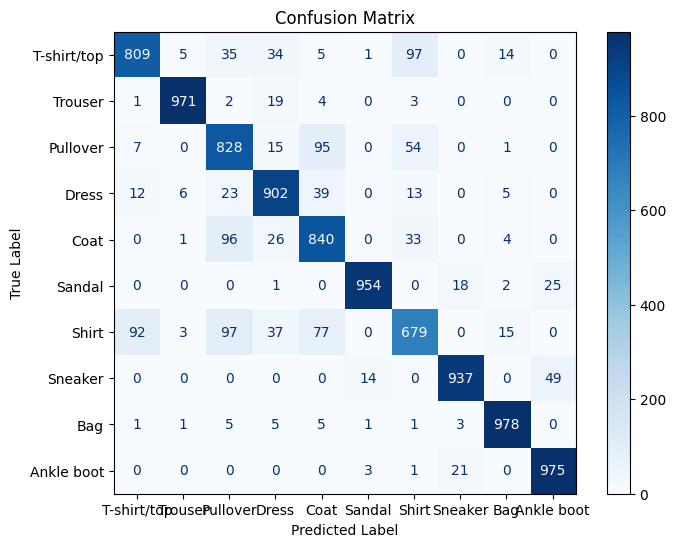

In [24]:
#Q7:From the above results, we found that Nadam achieved the highest accuracy of 89.5% with the following hyperparameters: activation = ReLU, layers = 3, hidden size = 128, initialization = Xavier, epochs = 10, batch size = 64.

#To generate the confusion matrix for the best model, we first retrieve the corresponding theta values, perform forward propagation to obtain y_pred,
# and then use these predictions to create the confusion matrix.

# Initialize W&B run
wandb.init(project='deep_learning_assignment_1', name='confusion_matrix_run')
theta1=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,64,3,128,'tanh','softmax','Xavier',0,10)
y_test_label=[]
y_test_pred_label=[]
m=x_test.shape[0]
for i in range(m):
  x_tes =x_test[i,:].reshape(-1,1)
  a,h,y_test_pred=forward_prop(x_tes.T,theta1,'tanh','softmax',3)
  y1=np.argmax(y_test[i,:].reshape(-1,1),axis=0)
  y_test_label.append(y1)
  # Get the index of the maximum probability for the current sample
  y2=np.argmax(y_test_pred)
  # Append only the predicted class label (integer) to the list
  y_test_pred_label.append(y2)
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt



# Compute confusion matrix
cm = confusion_matrix(y_test_label, y_test_pred_label)
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Log the confusion matrix plot to W&B
wandb.log({"Confusion Matrix": wandb.Image(fig)})

# Finish the W&B run
wandb.finish()


In [25]:
# question 8 : running a all the models for squared error loss and comapre them with previous one, for that i create another sweep and run all the models .
sweep_config={
    'method':'bayes',#possible search random,grid
    'metric':{
        'name':'Valdiation_accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[5,10]

        },
      'hidden_size':{
            'values':[32, 64, 128]
        },
        'activation_hidden':{
            'values':['relu','sigmoid','tanh']
        },
        'activation_output':{
            'values':['softmax']
        },
        'weight_ini_method':{
            'values':['Xavier','random']
        },
        'batch_size':{
            'values':[16,32,64]
        }
      ,'num_layers':{
            'values':[3,4,5]
        },
        'weight_decay':{
            'values':[0]#(we take l2 regulraization as zero)
        } ,
        'learning_rate':{
            'values':[1e-3,1e-4]
      }
        ,'optimizer':{
            'values':['sgd','momentum','nag','RMSprop','adam','nadam']
}
    }
}
sweep_id=wandb.sweep(sweep_config,project='deep_learning_assignment_1')

Create sweep with ID: dwsoxwyq
Sweep URL: https://wandb.ai/ma24m0-iit-madras/deep_learning_assignment_1/sweeps/dwsoxwyq


In [ ]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}_loss-{mse_loss}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'mse_loss')

try:
    wandb.agent(sweep_id,function=main,count=100)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: 4u6o5hw8 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.045555035405188515, Val Loss: 0.046293777208611546,Val Accuracy:0.6956666666666667
Epoch 2, Train Loss: 0.03560253372329564, Val Loss: 0.03639829676037021,Val Accuracy:0.7611666666666667
Epoch 3, Train Loss: 0.031237057713629116, Val Loss: 0.03201808488092269,Val Accuracy:0.7823333333333333
Epoch 4, Train Loss: 0.028945104537249, Val Loss: 0.029679628466887972,Val Accuracy:0.7971666666666667
Epoch 5, Train Loss: 0.02738131551197483, Val Loss: 0.028132379271372677,Val Accuracy:0.805
Epoch 6, Train Loss: 0.026291943406548085, Val Loss: 0.027053364922756465,Val Accuracy:0.813


In [ ]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'mse_loss')

try:
    wandb.agent(sweep_id,function=main,count=)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

In [ ]:
#Q 10 : download the mnist dataset and run this data set of three recomendation of best models obtain after hyper parameter search.


In [ ]:
from keras.datasets import mnist
(train_x1,train_y1),(test_x1,test_y1)=mnist.load_data()

x1_train,y1_train,x1_val,y1_val,x1_test,y1_test=tranform_dataset(train_x1,train_y1,test_x1,test_y1)

In [ ]:
#  optimizer redefined for recommendation and see the accuracy (code is almost same as before only here i remove the wandb log)
def re_mgd(lr, momentum, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")


    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)
    print(f'test_accuracy: {test_accuracy*100}')
    return theta

def re_adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")
    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)
    print(f'test_accuracy: {test_accuracy*100}')
    return theta



def re_nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay,epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train= x_train[indices]
        y_train = y_train[indices]

        for i in range(0,x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers,loss_function)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr*(m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss},Validation acuuracy:{validation_accuracy}")

    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)

    print(f'test_accuracy: {test_accuracy*100}')

    return theta




In [ ]:
#1st recomendation

theta=re_nadam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,x1_test,y1_test,64,3,128,'tanh','softmax','Xavier',0,10)

In [ ]:
#2nd recomendation

theta=re_adam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,x1_test,y1_test,64,3,128,'relu','softmax','Xavier',0,10)

In [ ]:
#3rd recomendation

theta=re_mgd(0.001,0.9,x1_train,y1_train,x1_val,y1_val,x1_test,y1_test,32,4,128,'relu','softmax','Xavier',0,10)